# Calisthenics Skills Pose Estimation
## Antonio Finocchiaro's progress diary

The purpose of this notebook is to track my progression and some thoughts about what I'm working for my thesis in CS followed by the Professor : Antonino Furnari.

The goal of this project is to create a sort of pipeline composed by two main sections to predict the various Calisthenics skills from a video and to count the seconds of the holds.
I decided to split this process in the first section, about Pose Estimation, made with Openpose model and the second one about the Classifier Neural Network to predict the video.
The building of the datasets will be in the first part. They'll be ready for the second one in a few months.

# <font color = green> 24/12/2022
<font color = black>
I worked in the last two days on my Openpose scripts, some codes to automatize some process and etc..
Starting from the skills I decided to identify : 

+ Planche (pl)
+ Front lever (fl)
+ One Arm Front Lever (oafl)
+ Iron Cross (ic)
+ Maltese (mal)
+ One Arm Handstandm (oahs)
+ Back Lever (bl)
+ Human Flag (hf)

I'll take soon the decision to include the *Victorian* or the *Front Lever touch* due to the similarity between them. 
The name closed in the bracket is the *id_skill* I'll use on the datasets to identify a skill.

# Openpose on Google Colab

Recently, I found a way to use Openpose on Colab without install it every time I change runtime or after the refreshing time of 12 hours. 
I installed Openpose on my google drive acccount (antosw2000@gmail.com) and everytime I open Colab I have to follow these steps : 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

I mount drive and copy the openpose directory to the "home"

In [ ]:
%cp -R /content/drive/MyDrive/openPose/openpose /content/

I reinstall the dependencies : 

In [ ]:
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

I change the permission of the build directory to make the system access the /build/examples/openpose/ folder  

In [ ]:
!chmod -R 777 build/

And today morning, I wrote the following code, to loop on a drive folder containing the video, process every video with some flags and then, put them in their specific folder : 

In [ ]:
# Specifica la cartella contenente i file video

import os

video_dir="/content/drive/MyDrive/datasetRaw/video_to_render/"

# Cicla attraverso tutti i file video nella cartella

for video_file in os.listdir(video_dir):
    
    # Esegui un'operazione su ogni file video (ad esempio, riprodurlo)
    #!echo "$(basename "$video_file")"

    video_name = video_file.split(".")[0]
    
    !mkdir -p /content/drive/MyDrive/datasetRaw/json_frames/$video_name    
        
    video_path = "/content/drive/MyDrive/datasetRaw/video_to_render/"+video_file
    json_output_path = "/content/drive/MyDrive/datasetRaw/json_frames/"+video_name+"/"
    video_output_path = "/content/drive/MyDrive/datasetRaw/out_video/"+video_file

    !./build/examples/openpose/openpose.bin \
    -keypoint_scale 3\
    --model_pose BODY_25B \
    --video {video_path} \
    --write_json {json_output_path} --display 0 \
    --number_people_max 1 \
    --write_video {video_output_path}

I decided to use the following flag :  `-keypoint_scale 3` to normalize the (x,y) keypoints couple to from file format to [0,1]. I'm using the model *BODY_25B* to have better accuracy than the COCO one. BODY_25B has 25 keypoints and they are the following : 

+ 0: 'Nose'
+ 1: 'LEye'
+ 2: 'REye'
+ 3: 'LEar'
+ 4: 'REar'
+ 5: 'LShoulder' 
+ 6: 'RShoulder'
+ 7: 'LElbow'
+ 8: 'RElbow'
+ 9: 'LWrist'
+ 10: 'RWrist'
+ 11: 'LHip'
+ 12: 'RHip'
+ 13: 'LKnee'
+ 14: 'RKnee'
+ 15: 'LAnkle'
+ 16: 'RAnkle'
+ 17: 'UpperNeck'
+ 18: 'HeadTop'
+ 19: 'LBigToe'
+ 20: 'LSmallToe'
+ 21: 'LHeel'
+ 22: 'RBigToe'
+ 23: 'RSmallToe'
+ 24: 'RHeel'

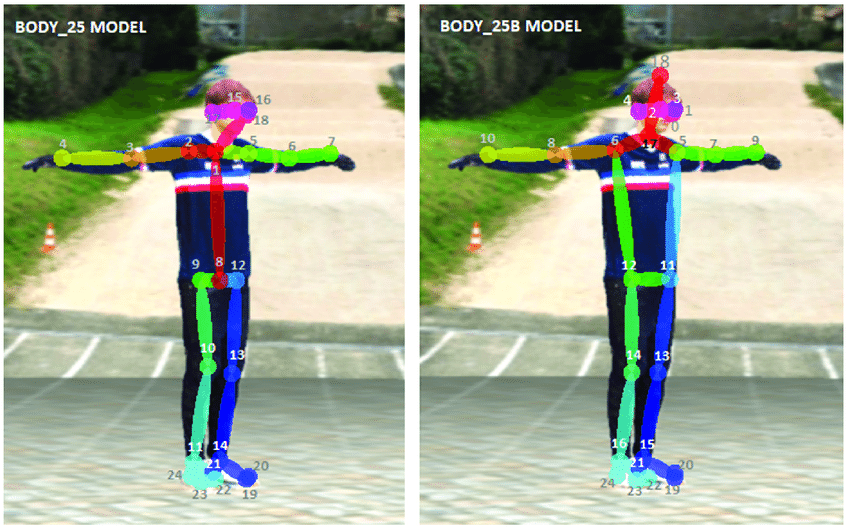

This is the comparative between the two models.

I tested the code in the previous cell and it worked! I am afraid about the usage that I can do on Colab, but I think to use it carefully and not so often; 
like rendering 10 videos a time. 

# Scripts to automize some processes

Then, having a google drive folder named "/datasetRaw/json_frames/" cointaining the folder of each video (with all keypoints inside); i worked with Google Drive API to make a script that download all the folders containing the keypoints in a local folder :  

In [ ]:
from Google import Create_Service
import os
import io 
from googleapiclient.http import MediaIoBaseDownload
import google.auth
import googleapiclient.discovery
import googleapiclient.errors
import shutil

CLIENT_SECRET_FILE = 'client_secret_GoogleCloud.json'
API_NAME = 'drive'
API_VERSION = 'v3'
SCOPES = ['https://www.googleapis.com/auth/drive']

service = Create_Service(CLIENT_SECRET_FILE, API_NAME, API_VERSION, SCOPES)

#print(dir(service))

parent_folder_id = '1Hu7Oxk82OvpCXmzK-3A2BttWw_us88ow'
local_directory = '/home/coloranto/Desktop/tesi/prova_script_keypoints/all_video_keypoints/'


# Recursively download the contents of the parent folder
def download_folder(folder_id, local_path):
    # Query for the list of files and folders in the current folder
    query = f"'{folder_id}' in parents and trashed = false"
    results = service.files().list(q=query, fields="nextPageToken, files(id, name, mimeType)").execute()
    items = results.get("files", [])
    # Download each file and recursively call this function for each folder
    for item in items:
        file_id = item['id']
        file = service.files().get(fileId=file_id).execute()
        file_name = file['name']
        if 'folder' in file['mimeType']:
            # Recursively call this function for the folder
            new_local_path = f'{local_path}/{file_name}'
            os.makedirs(new_local_path, exist_ok=True)
            download_folder(file_id, new_local_path)
        else:
            # Download the file
            print(f'Downloading file: {local_path}/{file_name}')
            request = service.files().get_media(fileId=file_id)
            fh = io.BytesIO()
            downloader = googleapiclient.http.MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()
            fh.seek(0)
            # Save the file to the local directory
            with open(f'{local_path}/{file_name}', 'wb') as f:
                f.write(fh.read())

# Create the local directory and start the recursive download
os.makedirs(local_directory, exist_ok=True)
download_folder(parent_folder_id, local_directory)

Google is a .py file I found to resolute the problems with authentication. 

In [ ]:
import pickle
import os
from google_auth_oauthlib.flow import Flow, InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload
from google.auth.transport.requests import Request


def Create_Service(client_secret_file, api_name, api_version, *scopes):
    print(client_secret_file, api_name, api_version, scopes, sep='-')
    CLIENT_SECRET_FILE = client_secret_file
    API_SERVICE_NAME = api_name
    API_VERSION = api_version
    SCOPES = [scope for scope in scopes[0]]
    print(SCOPES)

    cred = None

    pickle_file = f'token_{API_SERVICE_NAME}_{API_VERSION}.pickle'
    # print(pickle_file)

    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as token:
            cred = pickle.load(token)

    if not cred or not cred.valid:
        if cred and cred.expired and cred.refresh_token:
            cred.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRET_FILE, SCOPES)
            cred = flow.run_local_server()

        with open(pickle_file, 'wb') as token:
            pickle.dump(cred, token)

    try:
        service = build(API_SERVICE_NAME, API_VERSION, credentials=cred)
        print(API_SERVICE_NAME, 'service created successfully')
        return service
    except Exception as e:
        print('Unable to connect.')
        print(e)
        return None

def convert_to_RFC_datetime(year=1900, month=1, day=1, hour=0, minute=0):
    dt = datetime.datetime(year, month, day, hour, minute, 0).isoformat() + 'Z'
    return dt

I tested it and it works! By the way it has a big issue in terms of speed, the download speed is about 1 file/sec. This mean that to download a folder (representing a video) with about 150 json files, he'll need : 150 sec.
It has been a nice way to work with Google Drive API but I have to find a better solution in term of speed. 

Currently doing it manually, will drastically reduce the timing!

Then, between yesterday afternoon and today's one, I realized this code to do the following steps : 
+ Create a new .csv document and putting in it the first row containing 75 keypoints (x0,y0,c0,x1,y1,c1...) + 3 features : 'nome_video', 'frame_video', 'skill_id'
+ Extracting all the keypoints from the folder that I created with the previous script. Inside of them there are all the video keypoints, took by Openpose. 
+ Putting the .csv document created and extracted from the file name 2 features : 
    + from : 'flag1_000000000085_keypoints.json' I extracted the 'nome_video' : flag1 and the 'frame_video' : 85
    + the last feature I need is the id_skill, used to train later on this dataset. It take this information looping on another dataset I created : 


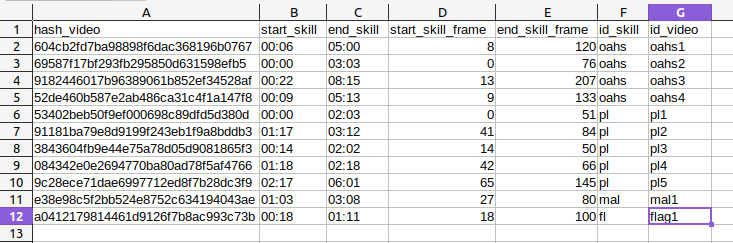

I compare the following nome_video and frame_video with all the rows present in this dataset and : 
if the nome_video is equal to the nome_video of the actual row and the frame_video is contained in the interval [start_skill_frame, end_skill_frame] I extract the skill_id and put it in the .csv I was creating. If the timeframe it's not contained in it, I'll use a generic label to identify the absence of skill : "null_skill", it will have 0 value on the final count.

This is the script I wrote : 

In [ ]:

import json
import csv
import glob
import re


with open('dataset.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['NoseX', 'NoseY', 'NoseC',
                                'LEyeX', 'LEyeY', 'LEyeC',
                                'REyeX', 'REyeY', 'REyeC',
                                'LEarX', 'LEarY', 'LEarC',
                                'REarX', 'REarY', 'REarC',
                                'LShoulderX', 'LShoulderY', 'LShoulderC',
                                'RShoulderX', 'RShoulderY', 'RShoulderC',
                                'LElbowX', 'LElbowY', 'LElbowC',
                                'RElbowX', 'RElbowY', 'RElbowC',
                                'LWristX', 'LWristY', 'LWristC',
                                'RWristX', 'RWristY', 'RWristC',
                                'LHipX', 'LHipY', 'LHipC',
                                'RHipX', 'RHipY', 'RHipC',
                                'LKneeX', 'LKneeY', 'LKneeC',
                                'RKneeX', 'RKneeY', 'RKneeC',
                                'LAnkleX', 'LAnkleY', 'LAnkleC',
                                'RAnkleX', 'RAnkleY', 'RAnkleC',
                                'UpperNeckX', 'UpperNeckY', 'UpperNeckC',
                                'HeadTopX', 'HeadTopY', 'HeadTopC',
                                'LBigToeX', 'LBigToeY', 'LBigToeC',
                                'LSmallToeX', 'LSmallToeY', 'LSmallToeC',
                                'LHeelX', 'LHeelY', 'LHeelC',
                                'RBigToeX', 'RBigToeY', 'RBigToeC',
                                'RSmallToeX', 'RSmallToeY', 'RSmallToeC',
                                'RHeelX', 'RHeelY', 'RHeelC',
                                'nome_video', 'frame_video', 'skill_id'])
    


#order alfabetically the folder
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

#loop on all json file in the folder
for i, folder in enumerate(glob.glob("./all_video_keypoints/*")):
    
    print("folder: ", folder)

    folder = natural_sort(glob.glob(folder + "/*"))
    
    for file in folder:
        
        #print(file)

        #read the json file
        with open(file) as f:
            data = json.load(f)
    

        if data["people"] == []:
            continue

        keypoints = data["people"][0]["pose_keypoints_2d"]
        
        name = file.split("/")[-1]
        name = name.split("_")
        nome_video = name[0]
    
        #print("nome_video vale: ", nome_video)

        #extracting the frame number without the 0 at the beginning
        frame_video = name[1]
        frame_video = frame_video.lstrip("0")
        if frame_video == "":
            frame_video = 0

        frame_video = int(frame_video)

        keypoints.append(nome_video)
        keypoints.append(frame_video)
    

        with open('dataset_video.csv', 'r') as f:
            reader = csv.reader(f)
            next(reader)
            sem = False
            for row in reader: 
                #print(row)


                #print("Compare ", nome_video, " with ", row[6])
                if nome_video == row[6] and frame_video >= int(row[3]) and frame_video <= int(row[4]):
                    #print("Sono uguali")
                    keypoints.append(row[6])
                    sem = True
                    break                
            
            if sem == False:
                keypoints.append("null_skill")

            
            print(keypoints)
        #write the keypoints in the csv file
        with open('dataset.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(keypoints)
            
#close the csv file
f.close()



I tested it and it works! This is the dataset.csv I obtain in output : 

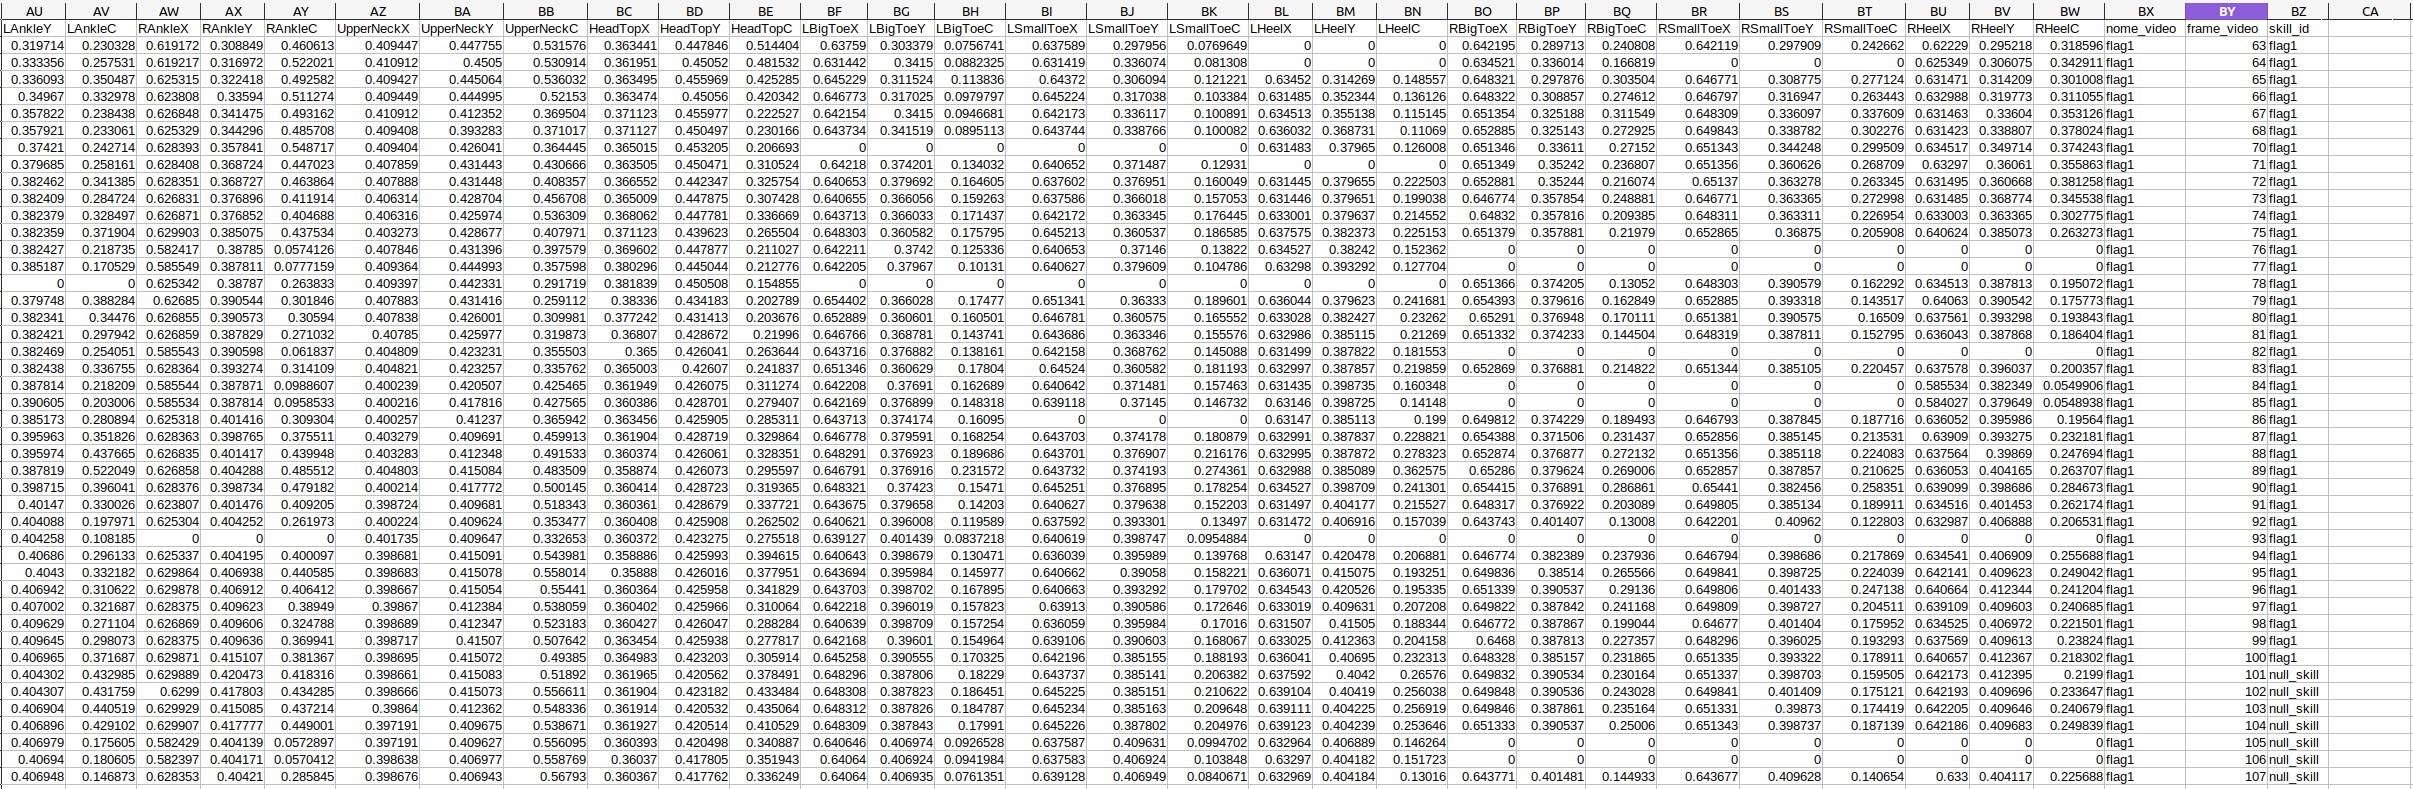

All the rows are the keypoints extracted, all the columns are the feature (78 in total). 
As we can see, the 'nome_video' column contain the indentifier of the video, 'frame_video' cointain the frame, 'skill_id' represent the **ground truth label**. 

NB : some frames are missing, this is voluntary, caused to the fact that in the video there are some frames with 0 keypoints; in this case the whole row will have all keypoints value to 0. This is a redundant data!

All the features are included between 0 and 1, it's a normalization to uniform the data. 

To build the video dataset, I am using a video editor software called **Kdenlive**, it's very easy to use and I render all videos with 960x540px resolution.
I find this resolution the best trade off between quality and compression, it's a 16:9 format, between the 1280x720 format and the 720x480 one.
All videos has 24 fps, no audio track and a hash value related. 

I am collecting them in a specific folder : 

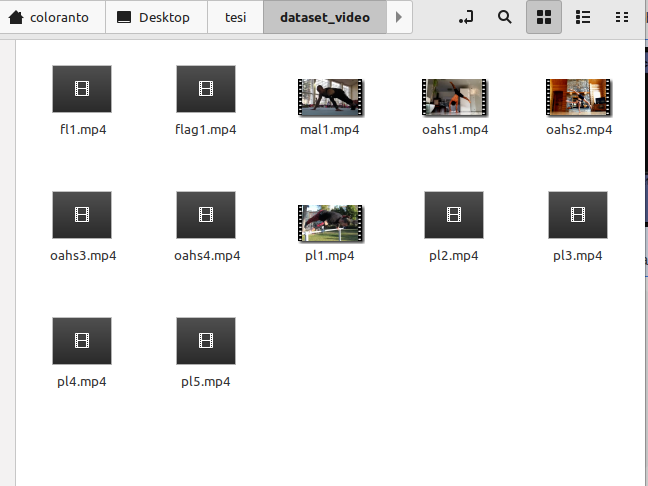

I know.. they are still only 12 videos but.. I'll increase them gradually over time!
My actually goal is to reach about 400-450 total video.

I had to resize this cause Openpose has serious difficult to detect the athlete if there are other people in the video and.. in lots of video, not all body part are present. 

These features, will make my job harder :(

I have lots of other info like all the integral video, all the kdenlive projects etc.. I'll find the best organization in few days. 
All the future updates and thoughts will be present on this notebook. I hope to go on collecting as more video as I can in the future weeks.


# <font color = green> 28/02/2023

<font color = black> 
    
</br>    
I started working on the first dataset containing the start/end frame of the skills, the id of the videos, the labels etc..
I reached about 320 videos already cut and converted in 960x540 resolution, with the proper line on the dataset. 
Currently I'm trying to balance the dataset cause certain skills are more popular than others. 

# <font color = green> 01/03/2023

<font color = black> 
    
</br> 

Today I wrote an algorithm that I'll need after the neural network chapter. I thought during the last period, about a way to correct the mistakes made by the classification related to every single frame. 
It all starts with the output of the classifier, a sort of csv where every row represent the skill made in that frame. For instance it could be : "pl", "mal" or "fl" and in absence of a specific movement : "none".
Every label refers to a specified frame and in a portion of time like 0.5 seconds it's physically impossible to change skills without having some "none" frames between; so if in a portion of frames there are some different skills, maybe there is a problem with the classifier but.. there's a way to help it to perform better. 
This algorithm I created it's divided in three main section : 
## The first one, is the following :
I read from the .csv file (in this following example, I created a sample one having about 61 frames) and applying some mechanism I manage to compress that number with the minimum loss, trying to recreate the real history. 
It's based on a windows and mode concept that divide the whole rows iteratively.
After many tries, I realized that the best size for the window is 3, so there's no significant loss with a good compression. We start from windows_size = 3, taking the first three labels and calculating the mode. 
If there's no value that has an occurrence higher than the others, I expand to windows_size+1 the size of the window, taking the fourth element and calculating again the mode and going on so..
When there's a value that is clearly the mode for instance : "fl", "pl", "none", "fl". I take "fl" as the current skill and keep on a list the first and the last frame of "fl". 

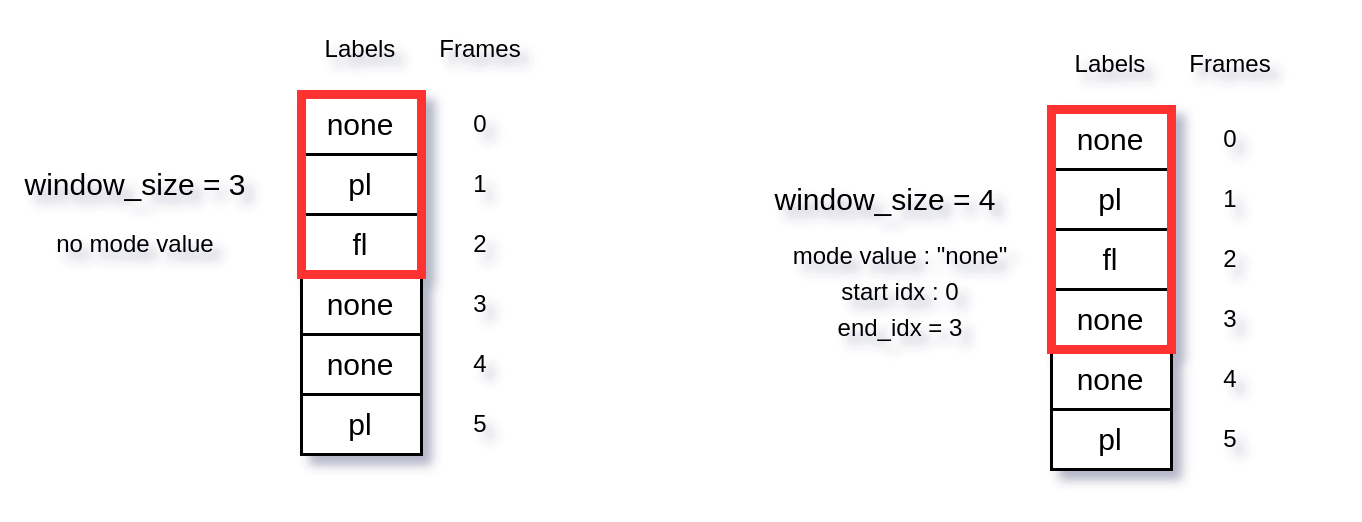    

Then, resetting the window_size to 3 and shift to a window_size-1 position forward, creating a soft sampling step that read some values two times (this is needed to be sure that the skill is the right one). 


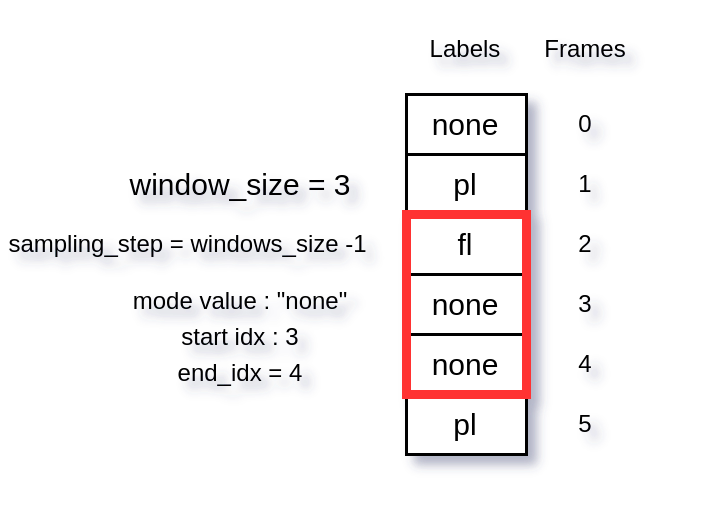
The output of the first part of the algorithm is a list of list where every sublist contain :  

["skill", global_start _index, global_end_index]

From 61 rows, we obtain a smaller set of skills, more specifically about 24 : 

['none', 'none', 'mal', 'mal', 'fl', 'mal', 'mal', 'pl', 'mal', 'none', 'mal', 'mal', 'mal', 'mal', 'mal', 'none', 'none', 'none', 'none', 'none', 'fl', 'fl', 'bl', 'fl']

But from a first look, we can notice that there are some skill that change too fast like that "fl" in the fifth position or that "pl" in the eighth one. 
We need to make a smart way to discard that skill seen that the others in both side are "mal" and surely it's right a maltese!

In [2]:
import pandas as pd
from scipy.stats import mode
import numpy as np


df = pd.read_csv("labels_sample.csv")


modes = []
modes_2_temp = []
#set the default size to 3
window_size = 3
temp_mode = []
i = window_size
while i <= len(df):
    values = df[i-window_size:i].iloc[:, 0]
    current_mode = values.mode()[0]

    if len(set(values)) == window_size:
        window_size += 1
        i+=1
       
    else:
        mode_value = mode(values)[0][0]

        min_index = values[values==mode_value].index.min()
        max_index = values[values==mode_value].index.max()

        temp_mode = [current_mode, min_index, max_index] 
        modes.append(temp_mode)
        modes_2_temp.append(current_mode)

        arr = values.values
        max_mode_index = np.where(arr == current_mode)[0][-1]
        window_size = 3
        i += window_size-1 
        
    
print(modes)
print(modes_2_temp)

[['none', 0, 3], ['none', 3, 4], ['mal', 8, 9], ['mal', 9, 12], ['fl', 13, 14], ['mal', 15, 18], ['mal', 18, 20], ['pl', 21, 22], ['mal', 23, 24], ['none', 25, 26], ['mal', 27, 30], ['mal', 30, 32], ['mal', 32, 34], ['mal', 34, 36], ['mal', 36, 38], ['none', 39, 41], ['none', 41, 43], ['none', 43, 45], ['none', 45, 47], ['none', 47, 49], ['fl', 50, 52], ['fl', 52, 55], ['bl', 56, 57], ['fl', 58, 60]]
['none', 'none', 'mal', 'mal', 'fl', 'mal', 'mal', 'pl', 'mal', 'none', 'mal', 'mal', 'mal', 'mal', 'mal', 'none', 'none', 'none', 'none', 'none', 'fl', 'fl', 'bl', 'fl']


## The second step of the algorithm is the following : 

As we can notice, the list obtained in the previous step need a tuning. 
I decided to proceed so : 
If the element of a list is the first one, I replace the first one (in loco) with the mode of the firsts three values.
If the element of a list in the last position, I replace the last one with the lasts three values. 
In all other cases, I replace the value of the current index with the mode basing on the previous, current and next value. So an example : 
["fl", "pl", "fl", ...]

The first value is surely a "fl", cause that's the mode
The second one, is a "fl" too cause the mode in the round, is still "fl" and so going on..
In a first sight I created another array, not modifying the current one but.. basing on the original array, there are some cases that break the mechanism as the following : 

['pl', 'pl', 'pl', 'mal', 'pl', 'none', 'none', 'none', 'none', 'fl', 'fl', 'fl', 'fl', 'fl', 'none', 'none', 'pl', 'pl']

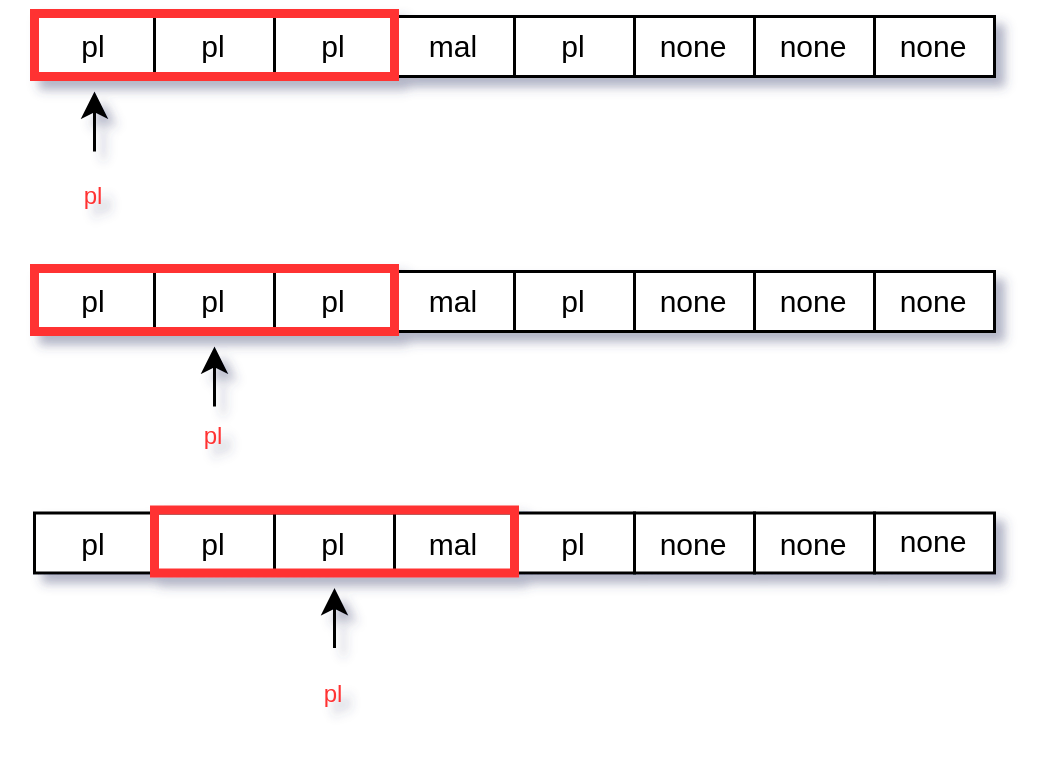


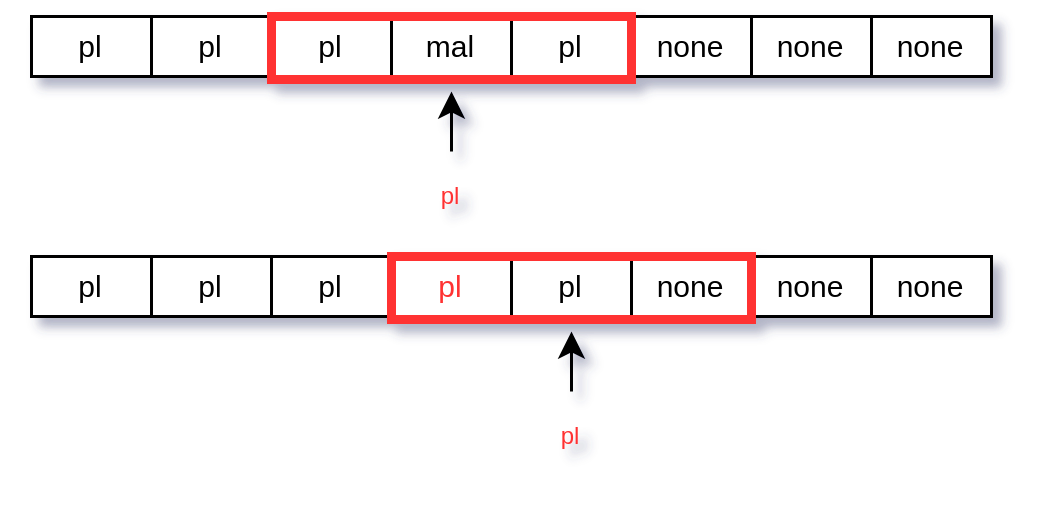

* Here, "mal" become "pl", but the "pl" in the fifth position, don't know what to become because it's round is ["mal", "pl", "none"] all different values. This is caused by the fact that the previous skill "mal", didn't get converted in "pl". Instead, making this change, this happen : 

['pl', 'pl', 'pl', 'pl', 'pl', 'none', 'none', 'none', 'none', 'fl', 'fl', 'fl', 'fl', 'fl', 'none', 'none', 'pl', 'pl']

It seems to work!

The code is the following : 

In [3]:
final_array = []
print(len(modes))
for i in range(0, len(modes)):
    patch_mode = []
    if i != 0 and i != len(modes)-1:
        patch_mode.append(modes[i-1][0])
        patch_mode.append(modes[i][0])
        patch_mode.append(modes[i+1][0])
        moda_ = mode(patch_mode)[0][0]
        modes[i][0] = moda_
        #final_array.append([mode(patch_mode)[0][0], modes[i][1], modes[i][2]])
    elif i == 0:
        patch_mode.append(modes[i][0])
        patch_mode.append(modes[i+1][0])
        patch_mode.append(modes[i+2][0])
        moda_ = mode(patch_mode)[0][0]
        modes[i][0] = moda_

        #final_array.append([mode(patch_mode)[0][0], modes[i][1], modes[i][2]])
    else:
        patch_mode.append(modes[i-2][0])
        patch_mode.append(modes[i-1][0])
        patch_mode.append(modes[i][0])
        moda_ = mode(patch_mode)[0][0]
        modes[i][0] = moda_
        
        #final_array.append([mode(patch_mode)[0][0], modes[i][1], modes[i][2]])
    
print(modes)

24
[['none', 0, 3], ['none', 3, 4], ['mal', 8, 9], ['mal', 9, 12], ['mal', 13, 14], ['mal', 15, 18], ['mal', 18, 20], ['mal', 21, 22], ['mal', 23, 24], ['mal', 25, 26], ['mal', 27, 30], ['mal', 30, 32], ['mal', 32, 34], ['mal', 34, 36], ['mal', 36, 38], ['none', 39, 41], ['none', 41, 43], ['none', 43, 45], ['none', 45, 47], ['none', 47, 49], ['fl', 50, 52], ['fl', 52, 55], ['fl', 56, 57], ['fl', 58, 60]]



## The thirtd step is about recreating the timestamp and the list of the skills done with the right time in milliseconds : 

A small but important consideration is for instance in this case : 

['none', 3, 4], ['mal', 8, 9]

We know that "none" end at the 4 frame, "mal" begin at the 8. Between these there are some "noises movement" that it's not good to consider as the begin of "mal", cause it would advantage the athlete without having a prove that the skill began in that point!
So we'll cover that hole with "none", saying that it ends at the 7 frame instead of the 4.
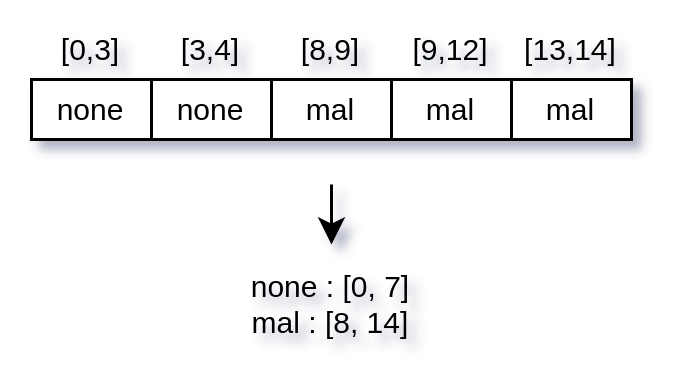

+ At last, I converted the frame in milliseconds basing on this formula : 
Recording with a 24 fps video, there are 24 frame in a second, so the range get multiplied by 1/24. 
Here's the code. 


Lista finale: 
[['none', 0, 7], ['mal', 8, 38], ['none', 39, 49], ['fl', 50, 60]]

Lista finale in millisecondi: 
[['none', 0.3333333333333333], ['mal', 1.2916666666666665], ['none', 0.4583333333333333], ['fl', 0.4583333333333333]]

x1 :  [0, 0.3333333333333333, 0.3333333333333333, 1.6249999999999998, 1.6249999999999998, 2.083333333333333, 2.083333333333333, 2.5416666666666665]

y1 :  ['none', 'none', 'mal', 'mal', 'none', 'none', 'fl', 'fl']


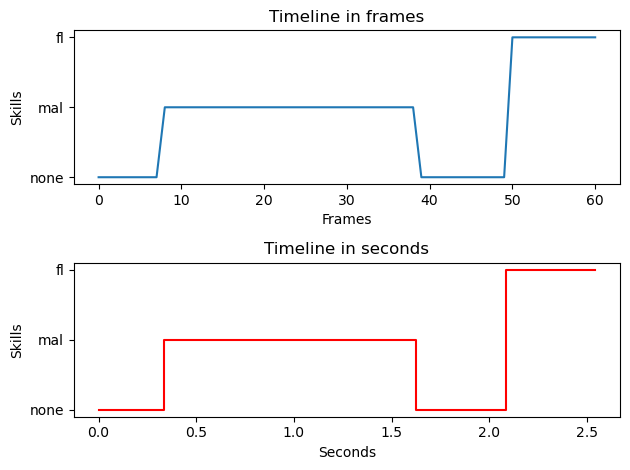

In [12]:
import matplotlib.pyplot as plt

output = []
output_l = []
i = 0
breakp = False
while i < len(modes)-1:
    skill = modes[i][0]
    start = modes[i][1]
    while i < len(modes)-1 and modes[i][0] == skill:
        i += 1

        if i == len(modes)-1:
            end = modes[i][2]
            breakp = True

    
    if breakp == False:
        end = (modes[i][1]-1)
    
    output.append([skill, start, end])
    milliseconds = ((end+1)-start)*(1/24)
    output_l.append([skill, milliseconds])

print("\nLista finale: ")
print(output)

print("\nLista finale in millisecondi: ")
print(output_l)

#now plot the two timelines

fig, (ax1, ax2) = plt.subplots(2, 1)

x = []
y = []
for i in range(0, len(output)):
    x.append(output[i][1])
    x.append(output[i][2])
    y.append(output[i][0])
    y.append(output[i][0])

#ax1.subplot(2, 1, 1)
ax1.plot(x, y)
ax1.set_title("Timeline in frames")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Skills")

x1 = []
y1= []
k = 0
for i in range(0, len(output_l)):
    x1.append(k)
    x1.append(k+output_l[i][1])
    y1.append(output_l[i][0])
    y1.append(output_l[i][0])
    k+=output_l[i][1]

print("\nx1 : ", x1)
print("\ny1 : ", y1)


#ax2.subplot(2, 1, 2)   
ax2.plot(x1, y1, color='red')
ax2.set_title("Timeline in seconds")
ax2.set_xlabel("Seconds")
ax2.set_ylabel("Skills")

fig.tight_layout()
plt.show()


# <font color = green> 04/03/2023

<font color = black> 
    
</br>    
I reached 403 videos on my dataset with the following occurrence : 

* Planche : 87
    
* Maltese : 90
    
* Back lever : 33
    
* Front Lever : 73
    
* One Arm Front Lever : 26
    
* One Arm Handstand : 71
    
* Flag : 11
    
* Iron Cross : 12

This little code show how many total frames are in the dataset.
Considering the previous occurrences, there are actually 33958 frames. Corrisponding to frames used to train the classifier. 

In [ ]:
df = pd.read_csv("dataset_video.csv")

total_frame = 0
for i in range(0, len(df)):
    current_frame = df.iloc[i, 4] - df.iloc[i, 3]
    total_frame += current_frame

print(total_frame)

# <font color = green> 07/03/2023

<font color = black> 
    
</br>    
It seems that I don't need Google Colab anymore cause I've just bought a rtx 3060 so.. the previous code in the first section became this one : 

In [ ]:
#!/bin/bash

video_dir="/home/coloranto/Documents/test/"

for video_file in $video_dir*; do

    video_name=$(basename "$video_file" | cut -f 1 -d '.')
    echo "$video_name"
    mkdir -p "/home/coloranto/Documents/output_op/json/$video_name"
        
    video_path="$video_file"
    json_output_path="/home/coloranto/Documents/output_op/json/$video_name/"
    video_output_path="/home/coloranto/Documents/output_op/videos/$video_name.avi"
    echo "$video_path"
    echo "$json_output_path"
    echo "$video_output_path"

    ./build/examples/openpose/openpose.bin \
    -keypoint_scale 3 \
    --model_pose BODY_25B \
    --net_resolution -1x480\
    --video "$video_path" \
    --write_json "$json_output_path" --display 0 \
    --number_people_max 1 \
    --write_video "$video_output_path"

done

I tested it and it works, I just need to solve a problem with cudnn and then I'll start to render the videos on the dataset.

There are lots of change, I didn't mention but that I'll discuss later.
This is the plot to a video I sent to the mlp.